# MS detection from MRI scans using a Quantum Support Vector Machine

In [1]:
# General Imports
import numpy as np

# Visualisation Imports
import matplotlib.pyplot as plt

#Os Import
import os

#Computer Vision imports
import cv2

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Pandas Imports
import pandas as pd

#Seaborn Imports
import seaborn as sns

# Qiskit Imports
from qiskit import Aer, execute, IBMQ
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

In [2]:
path = os.listdir('Training/')
classes = {'Healthy':0, 'Lesion':1}

In [3]:
X = []
Y = []
for cls in classes:
    pth = 'Training/'+cls
    for j in os.listdir(pth):
        img = cv2.imread(pth+'/'+j, 0)
        img = cv2.resize(img, (2,2))
        X.append(img)
        Y.append(classes[cls])

In [4]:
X = np.array(X)
Y = np.array(Y)

X_updated = X.reshape(len(X), -1)

In [5]:
np.unique(Y)

array([0, 1])

In [6]:
pd.Series(Y).value_counts()

1    827
0    395
dtype: int64

In [7]:
X.shape, X_updated.shape

((1222, 2, 2), (1222, 4))

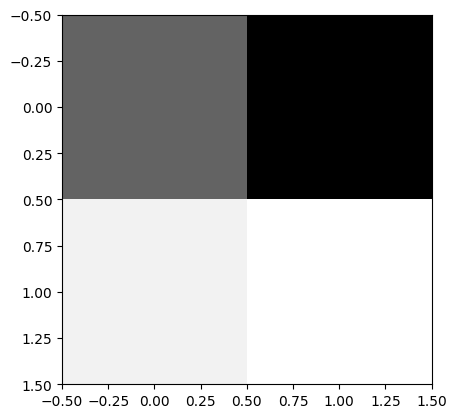

In [8]:
plt.imshow(X[0], cmap='gray')

In [9]:
X_updated = X.reshape(len(X), -1)
X_updated.shape

(1222, 4)

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(X_updated, Y, random_state=10,
                                               test_size=.20)

In [11]:
xtrain.shape, xtest.shape

((977, 4), (245, 4))

In [12]:
print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())
xtrain = xtrain/255
xtest = xtest/255
print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())

255 0
255 0
1.0 0.0
1.0 0.0


In [13]:
from sklearn.decomposition import PCA
print(xtrain.shape, xtest.shape)

pca = PCA(.98)
# pca_train = pca.fit_transform(xtrain)
# pca_test = pca.transform(xtest)
pca_train = xtrain
pca_test = xtest

(977, 4) (245, 4)


In [14]:
len(X_updated)

1222

In [15]:
zz_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

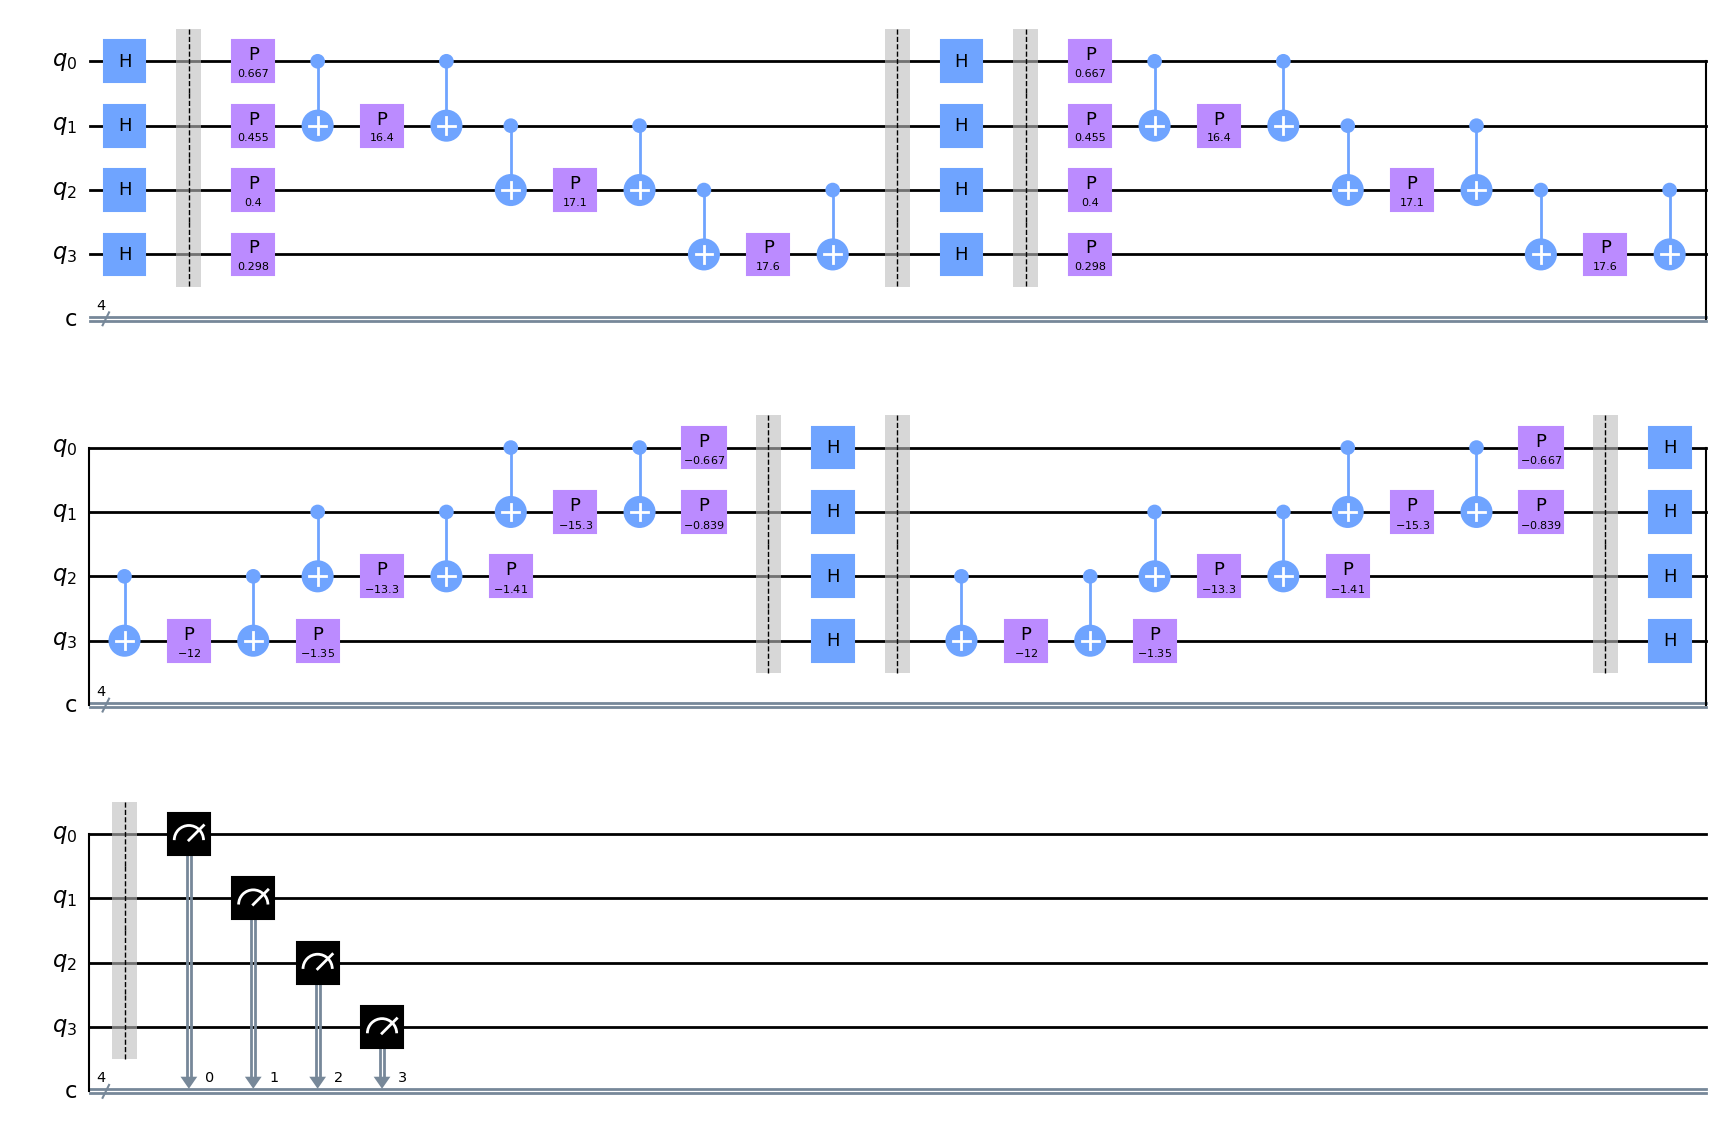

In [16]:
zz_circuit = zz_kernel.construct_circuit(xtrain[0],xtrain[1])
zz_circuit.decompose().decompose().draw(output='mpl')

In [17]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

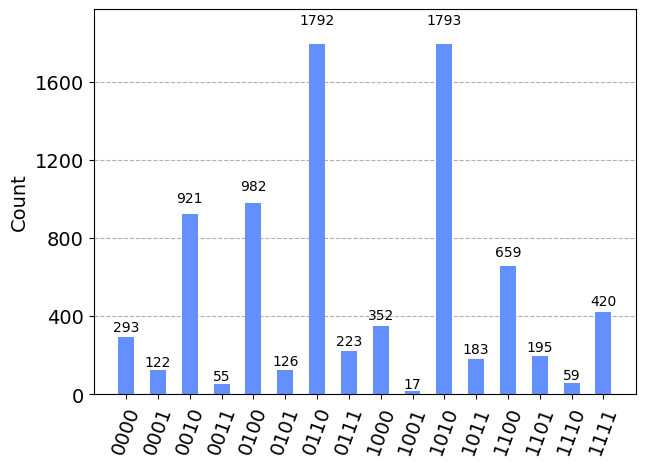

In [18]:
plot_histogram(counts)

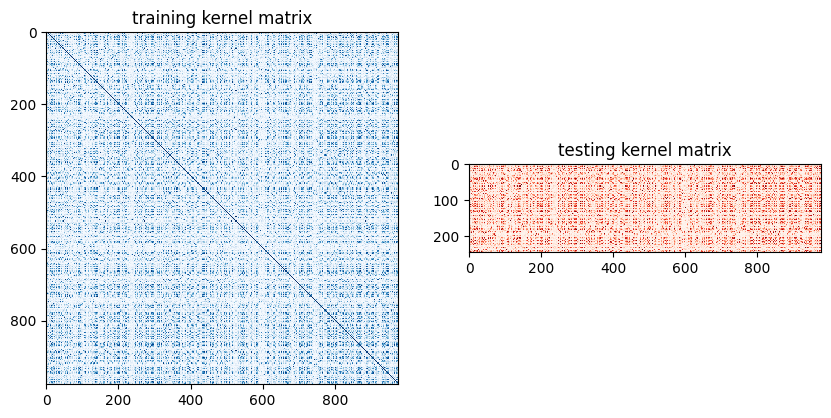

In [19]:
matrix_train = zz_kernel.evaluate(x_vec=xtrain)
matrix_test = zz_kernel.evaluate(x_vec=xtest, y_vec=xtrain)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

In [20]:
classical_kernels = ['linear'] #Linear kernel

for kernel in classical_kernels:
    zzpc_svc = SVC(kernel=kernel,C=10,gamma=100)
    zzpc_svc.fit(matrix_train, ytrain)
    zzpc_score = zzpc_svc.score(matrix_test, ytest)

    print('%s kernel classification test score:  %0.2f' % (kernel, zzpc_score))

linear kernel classification test score:  0.80


In [21]:
classical_kernels = ['rbf']
for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel,C=10,gamma=100)
    classical_svc.fit(xtrain, ytrain)
    classical_score = classical_svc.score(xtest, ytest)

    print('%s kernel classification test score:  %0.2f' % (kernel, classical_score))

rbf kernel classification test score:  0.84


In [22]:
#Final predictions on our Classical SVM
print(classical_svc.predict(xtest))

[1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1
 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0
 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 1
 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0
 1 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1]


In [23]:
#Final predictions on our QSVM
print(zzpc_svc.predict(matrix_test))

[1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1
 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 0
 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1]


In [24]:
#Checking matrix shape to determine the kernel size and resize the image accordingly
matrix_test[0].shape

(977,)

In [25]:
#Function for user-input
def predict(kernel,lesion_check):
    if kernel==1 and lesion_check==1:
        image_width=2
        image_height=2
        model = classical_svc
        path = 'Testing/Healthy/'
    elif kernel==1 and lesion_check==2:
        image_width=2
        image_height=2
        model = classical_svc
        path = 'Testing/Lesion/'
    elif kernel==2 and lesion_check==1:
        image_width=977
        image_height=1
        model = zzpc_svc
        path = 'Testing/Healthy/'
    elif kernel==2 and lesion_check==2:
        image_width=977
        image_height=1
        model = zzpc_svc
        path = 'Testing/Lesion/'
    plt.figure(figsize=(12,8))
    p = os.listdir('Testing/')
    c=1
    for i in os.listdir(path)[:16]:
        plt.subplot(4,4,c)

        img = cv2.imread(path+i,0)
        img1 = cv2.resize(img, (image_width,image_height))
        img1 = img1.reshape(1,-1)/255
        p = model.predict(img1)
        plt.title([p[0]])
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        c+=1

Test Model


Enter kernel choice
1.Classical Kernel
2.Quantum Kernel  2
Enter Area to check Lesion
1.Healthy
2.Lesion 2


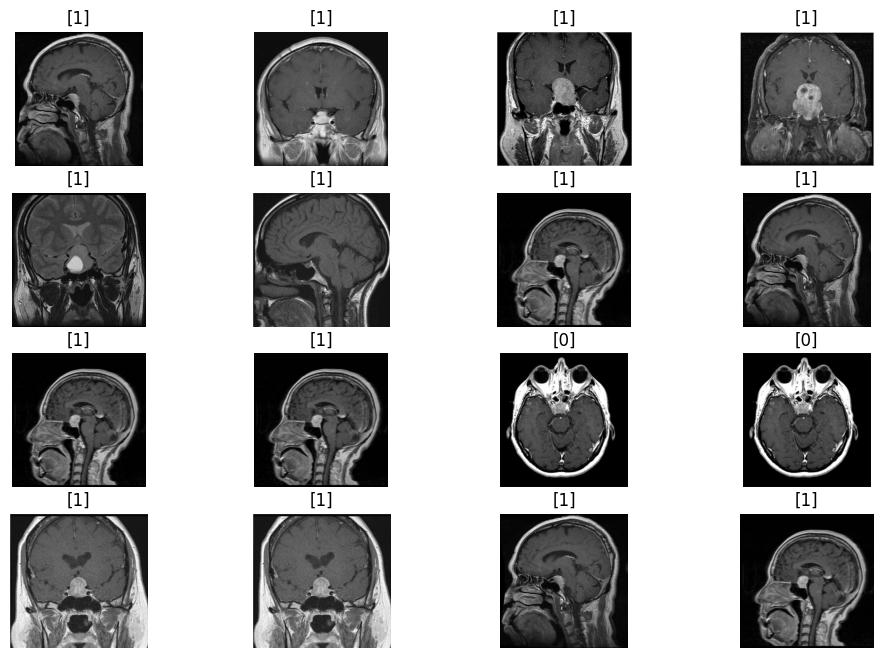

In [38]:
#Checking our Quantum Model
print("Test Model")
kernel= int(input("Enter kernel choice\n1.Classical Kernel\n2.Quantum Kernel "))
lesion_check= int(input("Enter Area to check Lesion\n1.Healthy\n2.Lesion"))
predict(kernel,lesion_check)

Test Model


Enter kernel choice
1.Classical Kernel
2.Quantum Kernel  2
Enter Area to check Lesion
1.Healthy
2.Lesion 2


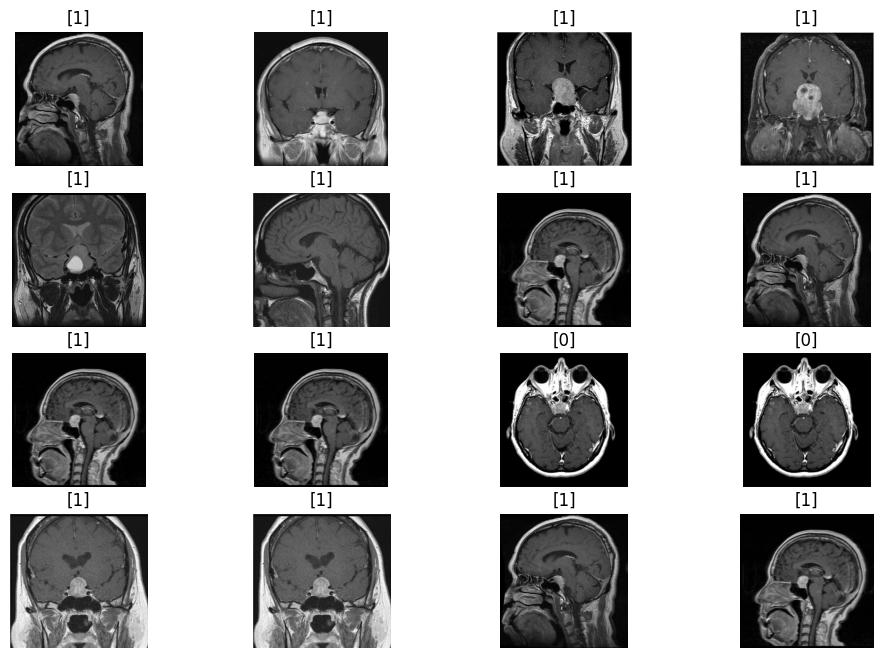

In [39]:
#Checking our Classical Model
print("Test Model")
kernel= int(input("Enter kernel choice\n1.Classical Kernel\n2.Quantum Kernel "))
lesion_check= int(input("Enter Area to check Lesion\n1.Healthy\n2.Lesion"))
predict(kernel,lesion_check)